In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
from modules.stn import STN
from modules.gridgen import CylinderGridGenV2, AffineGridGen, DenseAffine3DGridGen, DenseAffine3DGridGen_rotate, Depth3DGridGen
from PIL import Image
from matplotlib import mlab
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
from sklearn.neighbors import KDTree

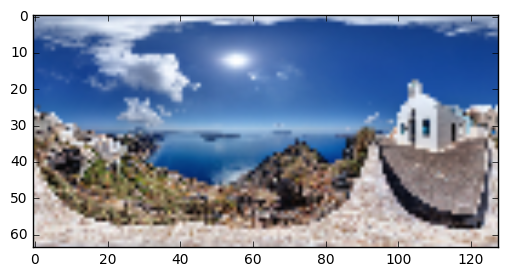

In [47]:
cgen = Depth3DGridGen(64, 128)
from PIL import ImageFilter
img = Image.open('equi.png').convert('RGB').resize((128,64))
img = np.array(img)/255.0
plt.imshow(img)
input1 = Variable(torch.from_numpy(np.expand_dims(img.astype(np.float32), 0)))
st = STN()
rotate = Variable(torch.from_numpy(np.array([[0.6]]).astype(np.float32)))
trans0 = Variable(torch.from_numpy(np.array([[0.5]]).astype(np.float32)))
trans1 =  Variable(torch.from_numpy(np.array([[0.4]]).astype(np.float32)))
depth = Variable(torch.ones(1,64,128,1), requires_grad = True)
out = cgen(depth, trans0, trans1, rotate)

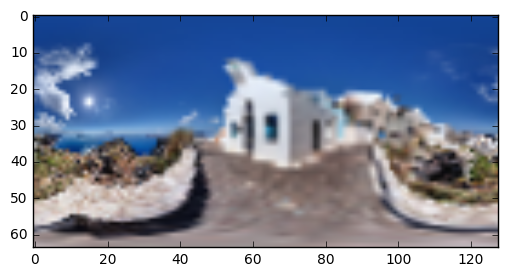

In [48]:
imgout = st(input1, out)
plt.imshow(imgout.data.numpy()[0][:,:,0:3])

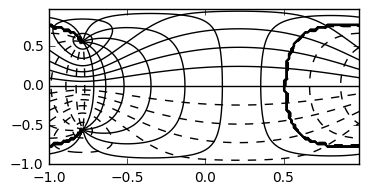

In [49]:
grid_data = out.data.numpy()[0]
delta = 0.025
x = np.arange(-1, 1, 2/128.0)
y = np.arange(-1, 1, 2/64.0)
X, Y = np.meshgrid(x, y)
Z1 = grid_data[:,:,0]
Z2 = grid_data[:,:,1]
fig = plt.figure(figsize=(4,2))
CS = plt.contour(X, Y, Z1, 15, colors='k')
#plt.clabel(CS, fontsize=9, inline=1)
CS = plt.contour(X, Y, Z2, 15, colors='k')
#plt.clabel(CS, fontsize=9, inline=1)

In [50]:
Z2.shape

(64, 128)

In [143]:
img = imgout.data.numpy()[0]

grid = grid_data
print img.shape, grid.shape

points = grid.reshape((64*128,2))
value = img.reshape((64*128,3))

(64, 128, 3) (64, 128, 2)


In [144]:
tree = KDTree(points)

In [160]:
new_img = np.zeros((64,128,3))
for i in range(64):
    for j in range(128):
        point = np.array([i/64.0 * 2 - 1, j/128.0 * 2 - 1])
        dist, ind = tree.query([point], k=3)  
        dist += 1e-5
        weight = (1/dist / np.sum(1/dist)).T
        new_img[i,j,:] = np.sum(value[ind[0]] * weight, 0)

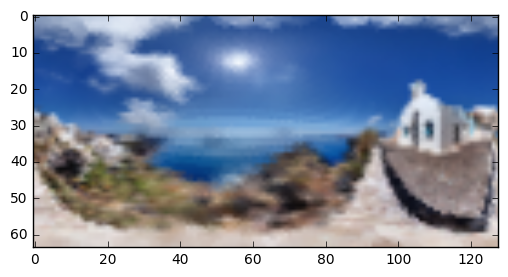

In [161]:
plt.imshow(new_img)

In [148]:
value[ind[0]] * np.exp(-dist ** 2).T

array([[ 0.78205047,  0.7002058 ,  0.63656005],
       [ 0.77735401,  0.69378373,  0.63641855],
       [ 0.87599805,  0.84274638,  0.82454259],
       [ 0.83112696,  0.74987732,  0.71731048],
       [ 0.81560792,  0.74806507,  0.71307876]])

In [149]:
weight = 1/dist / np.sum(1/dist)

In [150]:
np.sum(value[ind[0]] * weight, 1)

ValueError: operands could not be broadcast together with shapes (5,3) (1,5) 

In [162]:

def grid_sample_invert(img, grid, k=3):
    h,w,c = img.shape
    new_img = np.zeros((h,w,c))
    points = grid.reshape((h*w,2))
    value = img.reshape((h*w,3))
    
    tree = KDTree(points)
    
    new_img = np.zeros((h,w,3))
    for i in range(h):
        for j in range(w):
            point = np.array([i/float(h) * 2 - 1, j/float(w) * 2 - 1])
            dist, ind = tree.query([point], k=k)  
            dist += 1e-5
            weight = (1/dist / np.sum(1/dist)).T
            new_img[i,j,:] = np.sum(value[ind[0]] * weight, 0)
    return new_img

In [166]:
img_ = grid_sample_invert(img, grid, k = 5)

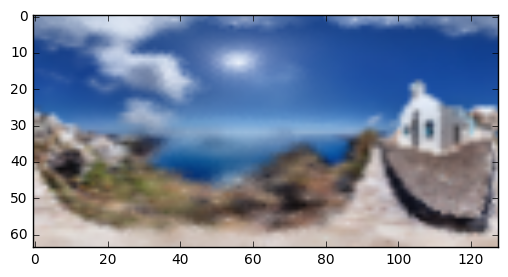

In [167]:
plt.imshow(img_)